# Import Libraries and Load Models

In [ ]:
import torch
torch.cuda.device_count()
import os
import sys; sys.path.append('../')
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *
import pickle
from data_wrapper import Data
from utils import *
from models import *
import cv2
from tqdm.notebook import tqdm_notebook
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from IPython.display import display
from fid_score.fid_score import FidScore
with open('../coco_fileDict.p', 'rb') as f:
    fileDict = pickle.load(f)

In [3]:
device = 'cuda:0'

In [6]:
state_dicts = torch.load('./state_dicts/result.pt', map_location=device)

In [7]:
models = {}
generator = Unet(UnetEncoder, UnetDecoder)
models['gen'] = generator
models['gen'].load_state_dict(state_dicts['gen'])

<All keys matched successfully>

In [ ]:
for k in models.keys():
    for x in models[k].parameters():
        x.requires_grad = False
    models[k].eval()
models['gen'].to(device)

# define a function to convert grayscale images to rgb ones

In [ ]:
from typing import Union, List, Tuple
from skimage.color import rgb2gray

In [ ]:
def cvtBW2RGB(x: np.ndarray, 
              size: Tuple[int] = (192, 192), 
              display: bool = True) -> np.ndarray :
    x = np.array(x)
    x = cv2.resize(x, size)
    assert len(x.shape) == 3
    if str(x.dtype).find('float')!=-1:
        print('Data ranges from 0 to 1')
    else:
        print('Data ranges from 0 to 255')
        x = x / 255.
    x = torch.from_numpy(x)[None].permute(0, 3, 1, 2)
    inp = (x.type(torch.float32) - 0.5)/0.5
    y = models['gen'](inp.to(device)).to('cpu')*0.5 + 0.5
    if display:
        fig, axs = plt.subplots(len(x), 2, figsize=(15, 15))
        if len(axs.shape) == 1:
            axs = axs[None]
        for i in range(len(x)):
            axs[i, 0].imshow(np.array(ToPILImage()(x[i])))
            axs[i, 1].imshow(np.array(ToPILImage()(y[i])))
    plt.show()
    y = np.array(y.permute(0, 2, 3, 1) * 255.).astype(np.uint8)
    return y[0]

In [ ]:
x = mpimg.imread('./images/wyoming-scenery-wallpaper-2.jpg')

In [ ]:
plt.imshow(x)

In [ ]:
x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)

In [ ]:
x = np.repeat(x[..., None], 3, -1)

In [ ]:
x.shape

In [ ]:
plt.imshow(x)

In [ ]:
2048/4/16

In [ ]:
1172/4/16

In [ ]:
y = cvtBW2RGB(x, size=(16*32, 16*18))

In [ ]:
test = [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]

In [ ]:
y_list = []

In [ ]:
for i in test:
    for name, module in models['gen'].named_modules():
        if 'fusion' in name:
            try:
                getattr(module, 'apply_noise')
                module.apply_noise = True
                module.noise_params['stddev'] = i
            except:
                pass
    y_list.append(cvtBW2RGB(x, size=(16*32, 16*18)))

In [ ]:
ys = np.array(y_list, int)

In [ ]:
len(y_list)

In [ ]:
for i in range(len(y_list) - 1):
    plt.imshow((np.abs(ys[0] - ys[i+1]) >=2).astype(float))
    plt.show()

# Video Colorization

In [ ]:
for name, module in models['gen'].named_modules():
    if 'fusion' in name:
        try:
            getattr(module, 'apply_noise')
            module.apply_noise = False
        except:
            pass

In [ ]:
cap = cv2.VideoCapture('/home/ai2020c/4K Video (Ultra HD) Unbelievable Beauty.mp4')

In [ ]:
cap.read()[1].shape

In [ ]:
640/16

In [ ]:
cap = cv2.VideoCapture('/home/ai2020c/3 Hours of Amazing Nature Scenery & Relaxing Music for Stress Relief.mp4')
size = (80*16, 44*16)
bs = 1
out_gen = cv2.VideoWriter('gen1.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30.0, size)
out_rgb = cv2.VideoWriter('rgb1.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30.0, size)
start = 20000
interval = 10000
f_stack = []
k = 0
for x in tqdm_notebook(range(start, start + interval)):
    cap.set(1, x)
    _, frame = cap.read()
    f = cv2.resize(frame, size)
    f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
    rgb_frame = f.astype(np.uint8)
    out_rgb.write(cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR))
    f = torch.from_numpy(f).permute(2, 0, 1) / 255.
    f = (f - 0.5)/0.5
    f = (Grayscale(3)(f)[None]).type(torch.float32)
    f_stack.append(f)
    if (x - start) % bs == bs - 1:
        f_stack = torch.cat(f_stack)
        gen_frame = models['gen'](f_stack.to(device)).cpu()*0.5 + 0.5
        gen_frame = (gen_frame.permute(0, 2, 3, 1).detach().numpy()*255).astype(np.uint8)
        for a in gen_frame:
            out_gen.write(cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
        f_stack = []
        if k%25==0:
            print('rgb')
            plt.imshow(rgb_frame)
            plt.show()
            print('gen')
            plt.imshow(gen_frame[-1])
            plt.show()
        k += 1
out_gen.release()
out_rgb.release()

In [ ]:
out_gen.release()
out_rgb.release()

# Model Evaluation

In [9]:
!rm -rf source_images_coco/ target_images_coco/

In [10]:
def display_result_real_fake(real, fake):
    if torch.is_tensor(real) and torch.is_tensor(fake):
        fig, axs = plt.subplots(1, 2, figsize=(20, 15))
        axs[0].imshow(np.array(ToPILImage()(make_grid(fake))))
        axs[0].set_title('fake')
        axs[1].imshow(np.array(ToPILImage()(make_grid(real))))
        axs[1].set_title('real')
        plt.show()

In [11]:
for name, module in models['gen'].named_modules():
    if 'fusion' in name:
        try:
            getattr(module, 'apply_noise')
            module.apply_noise = False
        except:
            pass

In [12]:
%mkdir source_images_coco/
%mkdir target_images_coco/

In [ ]:
size = (128, 128)
bs = 32
ds = Data(fileDict['train'], 'val', size)
train = DataLoader(ds, batch_size=bs)
ds = Data(fileDict['val'], 'val', size)
val = DataLoader(ds, batch_size=bs)
dl = {'Train': train, 'Val': val}
c_range_scale_factor = 1.
for phase in ['Train', 'Val']:
    print(phase)
    for i, d in tqdm_notebook(enumerate(dl[phase])):
        with torch.no_grad():
            x = d['bw']
            y = d['rgb']
            x = x*c_range_scale_factor
            fake = models['gen'](x.to(device))
            x = x.cpu()*0.5 + 0.5
            y = y.cpu()*0.5 + 0.5
            fake = fake.cpu()*0.5 + 0.5
            display_result_real_fake(y.cpu(), fake.cpu())

Train


0it [00:00, ?it/s]

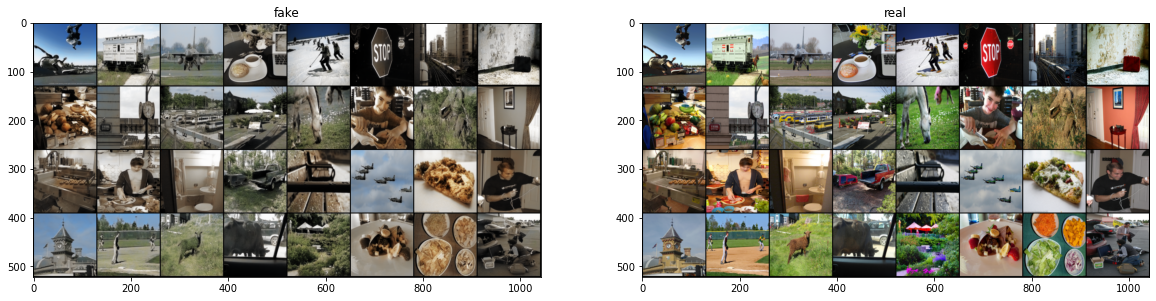

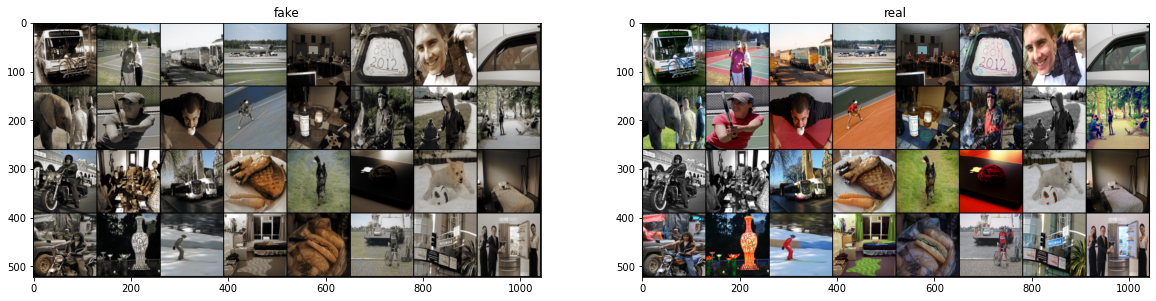

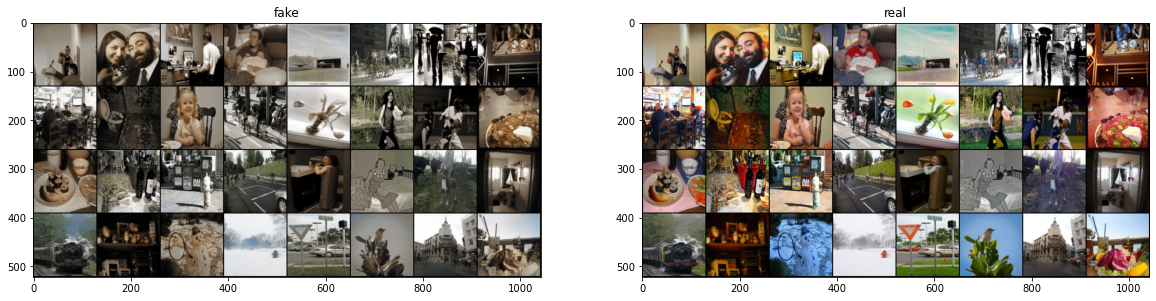

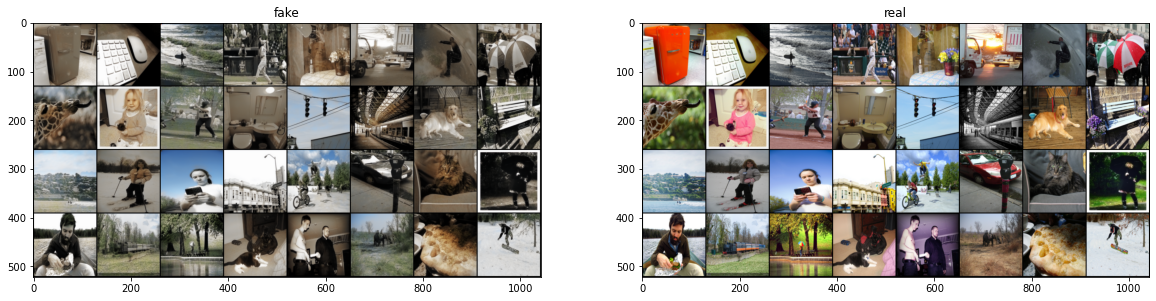

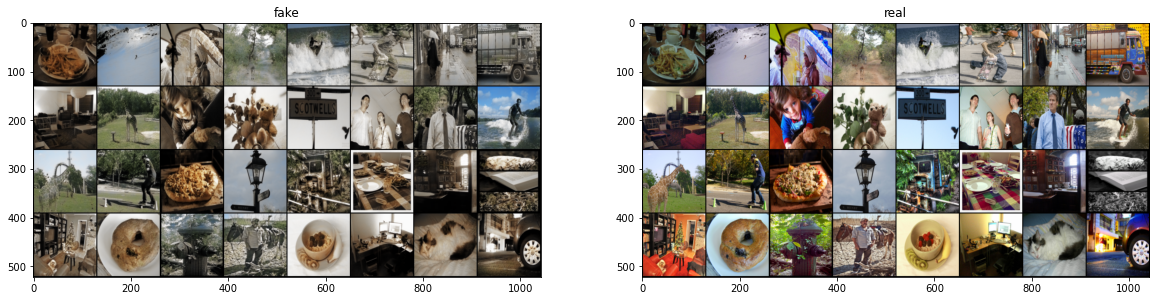

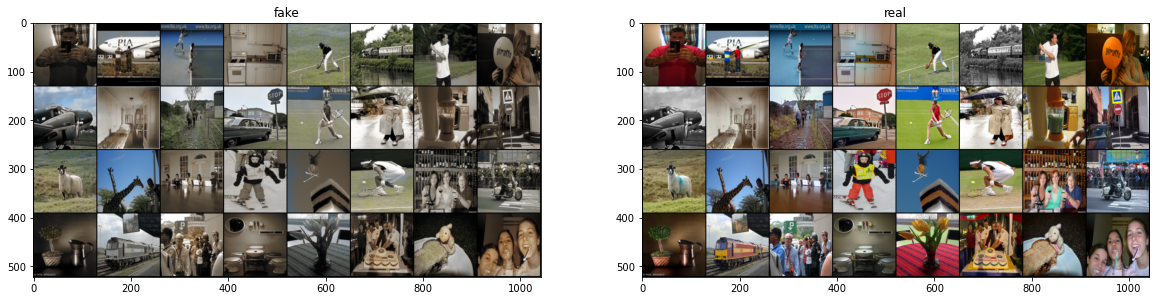

In [ ]:
size = (128, 128)
bs = 32
ds = Data(fileDict['train'], 'val', size)
train = DataLoader(ds, batch_size=bs)
ds = Data(fileDict['val'], 'val', size)
val = DataLoader(ds, batch_size=bs)
ds = Data(fileDict['test'], 'test', size)
test = DataLoader(ds, batch_size=bs)
dl = {'Train': train, 'Val': val, 'Test': test}
c_range_scale_factor = 1.
for phase in ['Train', 'Val', 'Test']:
    print(phase)
    source_path = f'./source_images_coco/{size[0]}'
    p = source_path + f'/{phase}'
    %mkdir {source_path}
    %mkdir {p}
    target_path = f'./target_images_coco/{size[0]}'
    p = target_path + f'/{phase}'
    %mkdir {target_path}
    %mkdir {p}
    for i, d in tqdm_notebook(enumerate(dl[phase])):
        with torch.no_grad():
            x = d['bw']
            y = d['rgb']
            x = x*c_range_scale_factor
            fake = models['gen'](x.to(device))
            x = x.cpu()*0.5 + 0.5
            y = y.cpu()*0.5 + 0.5
            fake = fake.cpu()*0.5 + 0.5
            # save images
            real_images = np.array((y*255.).permute(0, 2, 3, 1)).astype(np.uint8)
            fake_images = np.array((fake*255.).permute(0, 2, 3, 1)).astype(np.uint8)
            for j in range(len(real_images)):
                Image.fromarray(fake_images[j]).save(f'{source_path}/{phase}/{i*bs + j}.jpg')
                Image.fromarray(real_images[j]).save(f'{target_path}/{phase}/{i*bs + j}.jpg')
            display_result_real_fake(y.cpu(), fake.cpu())

# Original model Evaluation

In [ ]:
gen = get_generator().eval().to('cuda:1')
for x in gen.parameters():  
    x.requires_grad = False

In [ ]:
size = (128, 128)
bs = 32
ds = Data(fileDict['train'], 'val', size)
train = DataLoader(ds, batch_size=bs)
ds = Data(fileDict['val'], 'val', size)
val = DataLoader(ds, batch_size=bs)
ds = Data(fileDict['test'], 'val', size)
test = DataLoader(ds, batch_size=bs)
dl = {'Train': train, 'Val': val, 'Test': test}
mean = torch.tensor([0.485, 0.456, 0.406], device='cuda:1')[None, :, None, None]
std = torch.tensor([0.229, 0.224, 0.225], device='cuda:1')[None, :, None, None]
c_range_scale_factor = 0.95
discarded = (1 - c_range_scale_factor)
print(f'Scaling from 0~255 to {round(discarded*255./2, 2)} ~ {round(255. - discarded*255./2, 2)}')
for phase in ['Train', 'Val', 'Test']:
    print(phase)
    source_path = f'./source_images_deoldify/{size[0]}'
    p = source_path + f'/{phase}'
    %mkdir {source_path}
    %mkdir {p}
    target_path = f'./target_images_deoldify/{size[0]}'
    p = target_path + f'/{phase}'
    %mkdir {target_path}
    %mkdir {p}
    for i, d in tqdm_notebook(enumerate(dl[phase])):
        with torch.no_grad():
            x = d['bw']
            y = d['rgb']
            x = (x*c_range_scale_factor + discarded/2.)
            fake = gen((x.to('cuda:1') - mean)/std)*std + mean
            # save images
            real_images = np.array((y*255.).permute(0, 2, 3, 1)).astype(np.uint8)
            fake_images = np.array((fake*255.).permute(0, 2, 3, 1)).astype(np.uint8)
            for j in range(len(real_images)):
                Image.fromarray(fake_images[j]).save(f'{source_path}/{phase}/{i*bs + j}.jpg')
                Image.fromarray(real_images[j]).save(f'{target_path}/{phase}/{i*bs + j}.jpg')
            display_result_real_fake(y.cpu(), fake.cpu())

# Metrics (mse, psnr, ssim)

In [ ]:
for x in fileDict.values():
    print(len(x))

In [ ]:
import glob
import os
from tqdm.notebook import tqdm_notebook
from skimage import measure, metrics
from collections import defaultdict
from skimage.color import rgb2gray
from matplotlib import image as mpimg
import numpy as np
import cv2
import pandas as pd

In [ ]:
def calculate_metric_values(source_img_folder, target_img_folder, p=0.7):
    result = defaultdict(list)
    files_num = len(glob.glob(os.path.join(source_img_folder, '*.jpg')))
    for i in tqdm_notebook(range(files_num)):
        x_img = mpimg.imread(os.path.join(source_img_folder, f'{i}.jpg'))
        y_img = mpimg.imread(os.path.join(target_img_folder, f'{i}.jpg'))
        mse = metrics.mean_squared_error(y_img / 255., x_img / 255.)
        psnr = metrics.peak_signal_noise_ratio(cv2.cvtColor(y_img, cv2.COLOR_RGB2GRAY), cv2.cvtColor(x_img, cv2.COLOR_RGB2GRAY), data_range=255.)
        ssim = metrics.structural_similarity(y_img, x_img, data_range=255., multichannel=True)
        result['mse'].append(mse)
        result['psnr'].append(psnr)
        result['ssim'].append(ssim)
    result['mse'] = np.array(result['mse'])
    result['psnr'] = np.array(result['psnr'])
    result['ssim'] = np.array(result['ssim'])
    if p < 1.0:
        for i in result.keys():
            low = np.percentile(result[i], (1 - p)/2*100)
            high = np.percentile(result[i], (1 - (1 - p)/2)*100)
            filt = (result[i] >= low) & (result[i] < high)
            result[i] = result[i][filt]
    print({key: value.mean() for key, value in result.items()})
    return result

In [ ]:
phase = {'Train': None, 'Val': None, 'Test': None}

In [ ]:
for p in phase.keys():
    print(p)
    phase[p] = calculate_metric_values(f'./source_images_scenery/128/{p}', f'./target_images_scenery/128/{p}', p=1.0)

# FID Score

In [ ]:
from fid_score.fid_score import FidScore
from IPython.display import clear_output
import torch

In [ ]:
phase = ['Train', 'Val', 'Test']

In [ ]:
score = {}
for p in phase:
    print(p)
    fid = FidScore([f'./source_images_scenery/128/{p}', f'./target_images_scenery/128/{p}'], torch.device('cuda:1'))
    score[p] = fid.calculate_fid_score()
    print('*'*100)
    clear_output()
print(score)

In [ ]:
from torchinfo import summary

In [ ]:
summary(generator)

In [ ]:
14,059,056

In [ ]:
175,722,165

In [ ]:
coco.pt
coco_data
Train
100%
118060/118060 [17:52<00:00, 110.04it/s]

{'mse': 0.006179529222161775, 'psnr': 31.756681731743537, 'ssim': 0.9045837629631216}
Val
100%
4990/4990 [08:12<00:00, 10.14it/s]

{'mse': 0.006222936492892089, 'psnr': 31.743186629785132, 'ssim': 0.9046028568641719}
Test
100%
40640/40640 [07:47<00:00, 86.87it/s]

{'mse': 0.006228282897983277, 'psnr': 31.785377016423897, 'ssim': 0.9044514466481128}
{'Train': 15.326077910337233, 'Val': 22.72058448450133, 'Test': 15.563049215507078}

In [ ]:
coco.pt
scenery_data
Train
100%
3337/3337 [00:16<00:00, 208.12it/s]

{'mse': 0.00898878142719584, 'psnr': 31.847871654399707, 'ssim': 0.8896455301830865}
Val
100%
417/417 [00:02<00:00, 206.42it/s]

{'mse': 0.008952605689561672, 'psnr': 31.767449241126048, 'ssim': 0.8893759858608076}
Test
100%
418/418 [00:02<00:00, 207.26it/s]

{'mse': 0.008660139844135398, 'psnr': 31.99808968261077, 'ssim': 0.8901265667812326}
{'Train': 17.72884746621878, 'Val': 45.546358276715495, 'Test': 42.846136252562644}

In [ ]:
scenery.pt
scenery_data
Train
100%
3337/3337 [00:21<00:00, 158.89it/s]

{'mse': 0.005732453844876269, 'psnr': 30.068992200890065, 'ssim': 0.9011688775393658}
Val
100%
417/417 [00:02<00:00, 176.48it/s]

{'mse': 0.007560844318675922, 'psnr': 29.89681641902798, 'ssim': 0.8947862395833404}
Test
100%
418/418 [00:02<00:00, 177.29it/s]

{'mse': 0.007307980490520492, 'psnr': 30.25628108338683, 'ssim': 0.896589256840772}
{'Train': 12.789147356885024, 'Val': 39.271829377264226, 'Test': 35.50826270021503}